## Enter your backtest ID.
Note: the backtest needs to be longer than 2 years in order to receive a score.

In [1]:
# Replace the string below with your backtest ID.
bt = get_backtest('5a70ffcb0da48847ea9d6c6e')

100% Time: 0:00:11|###########################################################|


In [2]:
import empyrical as ep
import pyfolio as pf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from quantopian.research import returns

In [3]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS

def get_tradable_universe(start, end):
    """
    Gets the tradable universe in a format that can be compared to the positions
    of a backtest.
    """
    pipe = Pipeline(
        columns={'qtu':QTradableStocksUS()}
    )
    df = run_pipeline(pipe, start, end)
    df = df.unstack()
    df.columns = df.columns.droplevel()
    df = df.astype(float).replace(0, np.nan)
    return df

In [4]:
def volatility_adjusted_daily_return(trailing_algorithm_returns):
    """
    Normalize the last daily return in `trailing_algorithm_returns` by the annualized
    volatility of `trailing_algorithm_returns`.
    """
    
    todays_return = trailing_algorithm_returns[-1]
    # Volatility is floored at 2%.
    volatility = max(ep.annual_volatility(trailing_algorithm_returns), 0.02)
    score = (todays_return / volatility)
    
    return score

In [5]:
def compute_score(algorithm_returns):
    """
    Compute the score of a backtest from its algorithm_returns.
    """
    
    result = []
    
    cumulative_score = 0
    count = 0
    
    daily_scores = roll(
        algorithm_returns,
        function=volatility_adjusted_daily_return,
        window=63
    )
    
    cumulative_score = np.cumsum(daily_scores[441:])
    latest_score = cumulative_score[-1]
    
    print ''
    print 'Score computed between %s and %s.' % (cumulative_score.index[0].date(), daily_scores.index[-1].date())
    
    plt.plot(cumulative_score)
    plt.title('Out-of-Sample Score Over Time')
    print 'Cumulative Score: %f' % latest_score
    
    return cumulative_score

In [6]:
# This code is copied from the empyrical repository.
# Source: https://github.com/quantopian/empyrical/blob/master/empyrical/utils.py#L49
# Includes a fix to the bug reported here: https://github.com/quantopian/empyrical/issues/79
def roll(*args, **kwargs):
    """
    Calculates a given statistic across a rolling time period.
    Parameters
    ----------
    returns : pd.Series or np.ndarray
        Daily returns of the strategy, noncumulative.
        - See full explanation in :func:`~empyrical.stats.cum_returns`.
    factor_returns (optional): float / series
        Benchmark return to compare returns against.
    function:
        the function to run for each rolling window.
    window (keyword): int
        the number of periods included in each calculation.
    (other keywords): other keywords that are required to be passed to the
        function in the 'function' argument may also be passed in.
    Returns
    -------
    np.ndarray, pd.Series
        depends on input type
        ndarray(s) ==> ndarray
        Series(s) ==> pd.Series
        A Series or ndarray of the results of the stat across the rolling
        window.
    """
    func = kwargs.pop('function')
    window = kwargs.pop('window')
    if len(args) > 2:
        raise ValueError("Cannot pass more than 2 return sets")

    if len(args) == 2:
        if not isinstance(args[0], type(args[1])):
            raise ValueError("The two returns arguments are not the same.")

    if isinstance(args[0], np.ndarray):
        return _roll_numpy(func, window, *args, **kwargs)
    return _roll_pandas(func, window, *args, **kwargs)

def _roll_ndarray(func, window, *args, **kwargs):
    data = []
    for i in range(window, len(args[0]) + 1):
        rets = [s[i-window:i] for s in args]
        data.append(func(*rets, **kwargs))
    return np.array(data)


def _roll_pandas(func, window, *args, **kwargs):
    data = {}
    for i in range(window, len(args[0]) + 1):
        rets = [s.iloc[i-window:i] for s in args]
        data[args[0].index[i - 1]] = func(*rets, **kwargs)
    return pd.Series(data)

In [7]:
SECTORS = [
    'basic_materials', 'consumer_cyclical', 'financial_services',
    'real_estate', 'consumer_defensive', 'health_care', 'utilities',
    'communication_services', 'energy', 'industrials', 'technology'
]

STYLES = [
    'momentum', 'size', 'value', 'short_term_reversal', 'volatility'
]

POSITION_CONCENTRATION_98TH_MAX = 0.05
POSITION_CONCENTRATION_100TH_MAX = 0.1
LEVERAGE_0TH_MIN = 0.7
LEVERAGE_2ND_MIN = 0.8
LEVERAGE_98TH_MAX = 1.1
LEVERAGE_100TH_MAX = 1.2
DAILY_TURNOVER_0TH_MIN = 0.03
DAILY_TURNOVER_2ND_MIN = 0.05
DAILY_TURNOVER_98TH_MAX = 0.65
DAILY_TURNOVER_100TH_MAX = 0.8
NET_EXPOSURE_LIMIT_98TH_MAX = 0.1
NET_EXPOSURE_LIMIT_100TH_MAX = 0.2
BETA_TO_SPY_98TH_MAX = 0.3
BETA_TO_SPY_100TH_MAX = 0.4
SECTOR_EXPOSURE_98TH_MAX = 0.2
SECTOR_EXPOSURE_100TH_MAX = 0.25
STYLE_EXPOSURE_98TH_MAX = 0.4
STYLE_EXPOSURE_100TH_MAX = 0.5
TRADABLE_UNIVERSE_0TH_MIN = 0.9
TRADABLE_UNIVERSE_2ND_MIN = 0.95


def check_constraints(positions, transactions, algorithm_returns, risk_exposures):
    
    sector_constraints = True
    style_constraints = True
    constraints_met = 0
    num_constraints = 9
    
    # Position Concentration Constraint
    print 'Checking positions concentration limit...'
    try:
        percent_allocations = pf.pos.get_percent_alloc(positions[5:])
        daily_absolute_percent_allocations = percent_allocations.abs().drop('cash', axis=1)
        daily_max_absolute_position = daily_absolute_percent_allocations.max(axis=1)
        
        position_concentration_98 = daily_max_absolute_position.quantile(0.98)
        position_concentration_100 = daily_max_absolute_position.max()
        
    except IndexError:
        position_concentration_98 = -1
        position_concentration_100 = -1
        
    if (position_concentration_98 > POSITION_CONCENTRATION_98TH_MAX):
        print 'FAIL: 98th percentile position concentration of %.2f > %.1f.' % (
        position_concentration_98*100,
        POSITION_CONCENTRATION_98TH_MAX*100
    )
    elif (position_concentration_100 > POSITION_CONCENTRATION_100TH_MAX):
        print 'FAIL: 100th percentile position concentration of %.2f > %.1f.' % (
        position_concentration_100*100,
        POSITION_CONCENTRATION_100TH_MAX*100
    )
    else:
        print 'PASS: Max position concentration of %.2f%% <= %.1f%%.' % (
            position_concentration_98*100,
            POSITION_CONCENTRATION_98TH_MAX*100
        )
        constraints_met += 1

        
    # Leverage Constraint
    print ''
    print 'Checking leverage limits...'
    leverage = pf.timeseries.gross_lev(positions[5:])
    leverage_0 = leverage.min()
    leverage_2 = leverage.quantile(0.02)
    leverage_98 = leverage.quantile(0.98)
    leverage_100 = leverage.max()
    leverage_passed = True
    
    if (leverage_0 < LEVERAGE_0TH_MIN):
        print 'FAIL: Minimum leverage of %.2fx is below %.1fx' % (
            leverage_0,
            LEVERAGE_0TH_MIN
        )
        leverage_passed = False
    if (leverage_2 < LEVERAGE_2ND_MIN):
        print 'FAIL: 2nd percentile leverage of %.2fx is below %.1fx' % (
            leverage_2,
            LEVERAGE_2ND_MIN
        )
        leverage_passed = False
    if (leverage_98 > LEVERAGE_98TH_MAX):
        print 'FAIL: 98th percentile leverage of %.2fx is above %.1fx' % (
            leverage_98,
            LEVERAGE_98TH_MAX
        )
        leverage_passed = False
    if (leverage_100 > LEVERAGE_100TH_MAX):
        print 'FAIL: Maximum leverage of %.2fx is above %.1fx' % (
            leverage_0,
            LEVERAGE_0TH_MAX
        )
        leverage_passed = False
    if leverage_passed:
        print 'PASS: Leverage range of %.2fx-%.2fx is between %.1fx-%.1fx.' % (
            leverage_2,
            leverage_98,
            LEVERAGE_2ND_MIN,
            LEVERAGE_98TH_MAX
        )
        constraints_met += 1
      
    # Turnover Constraint
    print ''
    print 'Checking turnover limits...'
    turnover = pf.txn.get_turnover(positions, transactions, denominator='portfolio_value')
    # Compute mean rolling 63 trading day turnover.
    rolling_mean_turnover = roll(
        turnover, 
        function=pd.Series.mean,
        window=63)[62:]
    rolling_mean_turnover_0 = rolling_mean_turnover.min()
    rolling_mean_turnover_2 = rolling_mean_turnover.quantile(0.02)
    rolling_mean_turnover_98 = rolling_mean_turnover.quantile(0.98)
    rolling_mean_turnover_100 = rolling_mean_turnover.max()  
    rolling_mean_turnover_passed = True
    
    if (rolling_mean_turnover_0 < DAILY_TURNOVER_0TH_MIN):
        print 'FAIL: Minimum turnover of %.2f%% is below %.1f%%.' % (
            rolling_mean_turnover_0*100,
            DAILY_TURNOVER_0TH_MIN*100
        )
        rolling_mean_turnover_passed = False
    if (rolling_mean_turnover_2 < DAILY_TURNOVER_2ND_MIN):
        print 'FAIL: 2nd percentile turnover of %.2f%% is below %.1fx' % (
            rolling_mean_turnover_2*100,
            DAILY_TURNOVER_2ND_MIN*100
        )
        rolling_mean_turnover_passed = False
    if (rolling_mean_turnover_98 > DAILY_TURNOVER_98TH_MAX):
        print 'FAIL: 98th percentile turnover of %.2f%% is above %.1fx' % (
            rolling_mean_turnover_98*100,
            DAILY_TURNOVER_98TH_MAX*100
        )
        rolling_mean_turnover_passed = False
    if (rolling_mean_turnover_100 > DAILY_TURNOVER_100TH_MAX):
        print 'FAIL: Maximum turnover of %.2f%% is above %.1fx' % (
            rolling_mean_turnover_100*100,
            DAILY_TURNOVER_100TH_MAX*100
        )
        rolling_mean_turnover_passed = False
    if rolling_mean_turnover_passed:
        print 'PASS: Mean turnover range of %.2f%%-%.2f%% is between %.1f%%-%.1f%%.' % (
            rolling_mean_turnover_2*100,
            rolling_mean_turnover_98*100,
            DAILY_TURNOVER_2ND_MIN*100,
            DAILY_TURNOVER_98TH_MAX*100
        )
        constraints_met += 1

        
    # Net Exposure Constraint
    print ''
    print 'Checking net exposure limit...'
    net_exposure = pf.pos.get_long_short_pos(positions[5:])['net exposure'].abs()
    net_exposure_98 = net_exposure.quantile(0.98)
    net_exposure_100 = net_exposure.max()
    
    if (net_exposure_98 > NET_EXPOSURE_LIMIT_98TH_MAX):
        print 'FAIL: 98th percentile net exposure (absolute value) of %.2f > %.1f.' % (
        net_exposure_98*100,
        NET_EXPOSURE_LIMIT_98TH_MAX*100
    )
    elif (net_exposure_100 > NET_EXPOSURE_LIMIT_100TH_MAX):
        print 'FAIL: 100th percentile net exposure (absolute value) of %.2f > %.1f.' % (
        net_exposure_100*100,
        NET_EXPOSURE_LIMIT_100TH_MAX*100
    )
    else:
        print 'PASS: Net exposure (absolute value) of %.2f%% <= %.1f%%.' % (
            net_exposure_98*100,
            NET_EXPOSURE_LIMIT_98TH_MAX*100
        )
        constraints_met += 1
    
        
    # Beta Constraint
    print ''
    print 'Checking beta-to-SPY limit...'
    spy_returns = returns(
        symbols('SPY'),
        algorithm_returns.index[0],
        algorithm_returns.index[-1],
    )
    beta = roll(
        algorithm_returns,
        spy_returns,
        function=ep.beta,
        window=126
    ).reindex_like(algorithm_returns).fillna(0).abs()
    beta_98 = beta.quantile(0.98)
    beta_100 = beta.max()
    if (beta_98 > BETA_TO_SPY_98TH_MAX):
            print 'FAIL: 98th percentile absolute beta of %.3f > %.1f.' % (
            beta_98,
            BETA_TO_SPY_98TH_MAX
        )
    elif (beta_100 > BETA_TO_SPY_100TH_MAX):
        print 'FAIL: 100th percentile absolute beta of %.3f > %.1f.' % (
            beta_100,
            BETA_TO_SPY_100TH_MAX
        )
    else:
        print 'PASS: Max absolute beta of %.3f <= %.1f.' % (
            beta_98,
            BETA_TO_SPY_98TH_MAX
        )
        constraints_met += 1
        
    # Risk Exposures
    rolling_mean_risk_exposures = risk_exposures.rolling(63, axis=0).mean()[62:].fillna(0)
    
    # Sector Exposures
    print ''
    print 'Checking sector exposure limits...'
    for sector in SECTORS:
        absolute_mean_sector_exposure = rolling_mean_risk_exposures[sector].abs()
        abs_mean_sector_exposure_98 = absolute_mean_sector_exposure.quantile(0.98)
        abs_mean_sector_exposure_100 = absolute_mean_sector_exposure.max()
        if (abs_mean_sector_exposure_98 > SECTOR_EXPOSURE_98TH_MAX):
            print 'FAIL: 98th percentile %s exposure of %.3f (absolute value) is greater than %.2f.' % (
                sector,
                abs_mean_sector_exposure_98,
                SECTOR_EXPOSURE_98TH_MAX
            )
            sector_constraints = False
        elif (abs_mean_sector_exposure_100 > SECTOR_EXPOSURE_100TH_MAX):
            max_sector_exposure_day = absolute_mean_sector_exposure.idxmax()
            print 'FAIL: Max %s exposure of %.3f (absolute value) on %s is greater than %.2f.' % (
                sector,
                abs_mean_sector_exposure_100,
                max_sector_exposure_day,
                SECTOR_EXPOSURE_100TH_MAX
            )
            sector_constraints = False
    if sector_constraints:
        print 'PASS: All sector exposures were between +/-%.2f.' % SECTOR_EXPOSURE_98TH_MAX
        constraints_met += 1
        
    # Style Exposures
    print ''
    print 'Checking style exposure limits...'
    for style in STYLES:
        absolute_mean_style_exposure = rolling_mean_risk_exposures[style].abs()
        abs_mean_style_exposure_98 = absolute_mean_style_exposure.quantile(0.98)
        abs_mean_style_exposure_100 = absolute_mean_style_exposure.max()
        if (abs_mean_style_exposure_98 > STYLE_EXPOSURE_98TH_MAX):
            print 'FAIL: 98th percentile %s exposure of %.3f (absolute value) is greater than %.2f.' % (
                style, 
                abs_mean_style_exposure_98, 
                STYLE_EXPOSURE_98TH_MAX
            )
            style_constraints = False
        elif (abs_mean_style_exposure_100 > STYLE_EXPOSURE_100TH_MAX):
            max_style_exposure_day = absolute_mean_style_exposure.idxmax()
            print 'FAIL: Max %s exposure of %.3f (absolute value) on %s is greater than %.2f.' % (
                style, 
                abs_mean_style_exposure_100, 
                max_style_exposure_day.date(),
                STYLE_EXPOSURE_100TH_MAX
            )
            style_constraints = False
    if style_constraints:
        print 'PASS: All style exposures were between +/-%.2f.' % STYLE_EXPOSURE_98TH_MAX
        constraints_met += 1
    
    
    # Tradable Universe
    print ''
    print 'Checking investment in tradable universe...'
    positions_wo_cash = positions.drop('cash', axis=1)
    positions_wo_cash = positions_wo_cash.abs()
    total_investment = positions_wo_cash.fillna(0).sum(axis=1)
    daily_qtu_investment = universe.multiply(positions_wo_cash).fillna(0).sum(axis=1)
    percent_in_qtu = daily_qtu_investment / total_investment
    percent_in_qtu = percent_in_qtu[5:].fillna(0)
    
    percent_in_qtu_0 = percent_in_qtu.min()
    percent_in_qtu_2 = percent_in_qtu.quantile(0.02)
        
    if percent_in_qtu_0 < TRADABLE_UNIVERSE_0TH_MIN:
        min_percent_in_qtu_date = percent_in_qtu.argmin()
        print 'FAIL: Minimum investment in QTradableStocksUS of %.2f%% on %s is < %.1f%%.' % (
            percent_in_qtu_0*100, 
            min_percent_in_qtu_date.date(),
            TRADABLE_UNIVERSE_0TH_MIN*100
        )
    elif percent_in_qtu_2 < TRADABLE_UNIVERSE_2ND_MIN:
        print 'FAIL: Investment in QTradableStocksUS (2nd percentile) of %.2f%% is < %.1f%%.' % (
            percent_in_qtu_2*100, 
            TRADABLE_UNIVERSE_2ND_MIN*100
        )
    else:
        print 'PASS: Investment in QTradableStocksUS is >= %.1f%%.' % (
            TRADABLE_UNIVERSE_2ND_MIN*100
        )
        constraints_met += 1
        
        
    # Total algorithm_returns Constraint
    print ''
    print 'Checking that algorithm has positive algorithm_returns...'
    cumulative_algorithm_returns = ep.cum_returns_final(algorithm_returns)
    if (cumulative_algorithm_returns > 0):
        print 'PASS: Cumulative algorithm_returns of %.2f is positive.' % (
            cumulative_algorithm_returns
        )
        constraints_met += 1
    else:
        print 'FAIL: Cumulative algorithm_returns of %.2f is negative.' % (
            cumulative_algorithm_returns
        )
    
    print ''
    print 'Results:'
    if constraints_met == num_constraints:
        print 'All constraints met!'
    else:
        print '%d/%d tests passed.' % (constraints_met, num_constraints)

In [8]:
def evaluate_backtest(positions, transactions, algorithm_returns, risk_exposures):
    if len(positions.index) > 504:
        check_constraints(positions, transactions, algorithm_returns, risk_exposures)
        score = compute_score(algorithm_returns[start:end])
    else:
        print 'ERROR: Backtest must be longer than 2 years to be evaluated.'

#### Transform some of the data.

In [9]:
positions = bt.pyfolio_positions
transactions = bt.pyfolio_transactions
algorithm_returns = bt.daily_performance.returns
factor_exposures = bt.factor_exposures

start = positions.index[0]
end = positions.index[-1]
universe = get_tradable_universe(start, end)
universe.columns = universe.columns.map(lambda x: '%s-%s' % (x.symbol, x.sid))

#### Run this to evaluate your algorithm. Note that the new contest will require all filters to pass before a submission is eligible to participate.

Checking positions concentration limit...
PASS: Max position concentration of 1.34% <= 5.0%.

Checking leverage limits...
PASS: Leverage range of 0.95x-1.05x is between 0.8x-1.1x.

Checking turnover limits...
PASS: Mean turnover range of 19.15%-28.04% is between 5.0%-65.0%.

Checking net exposure limit...
PASS: Net exposure (absolute value) of 1.29% <= 10.0%.

Checking beta-to-SPY limit...
PASS: Max absolute beta of 0.151 <= 0.3.

Checking sector exposure limits...
PASS: All sector exposures were between +/-0.20.

Checking style exposure limits...
PASS: All style exposures were between +/-0.40.

Checking investment in tradable universe...
PASS: Investment in QTradableStocksUS is >= 95.0%.

Checking that algorithm has positive algorithm_returns...
PASS: Cumulative algorithm_returns of 0.38 is positive.

Results:
All constraints met!

Score computed between 2013-01-04 and 2014-12-12.
Cumulative Score: 4.520568


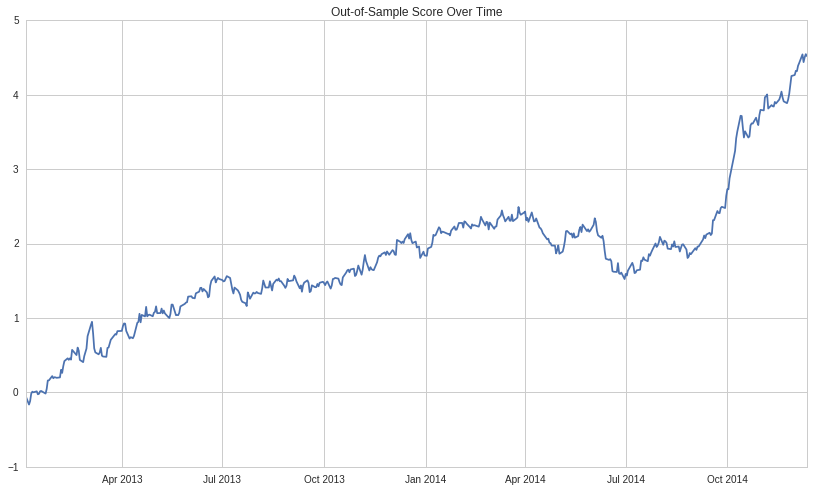

In [10]:
evaluate_backtest(positions, transactions, algorithm_returns, factor_exposures)

Start date,2011-01-05
End date,2014-12-12
Total months,47
,Backtest
Annual return,8.6%
Cumulative returns,38.5%
Annual volatility,5.1%
Sharpe ratio,1.63
Calmar ratio,1.80
Stability,0.87
Max drawdown,-4.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.79,2011-10-14,2012-05-01,2013-02-07,345
1,3.98,2014-03-26,2014-06-30,2014-09-22,129
2,2.72,2011-08-08,2011-08-15,2011-09-23,35
3,2.20,2013-07-05,2013-07-23,2013-10-21,77
4,2.19,2013-03-05,2013-03-18,2013-04-16,31


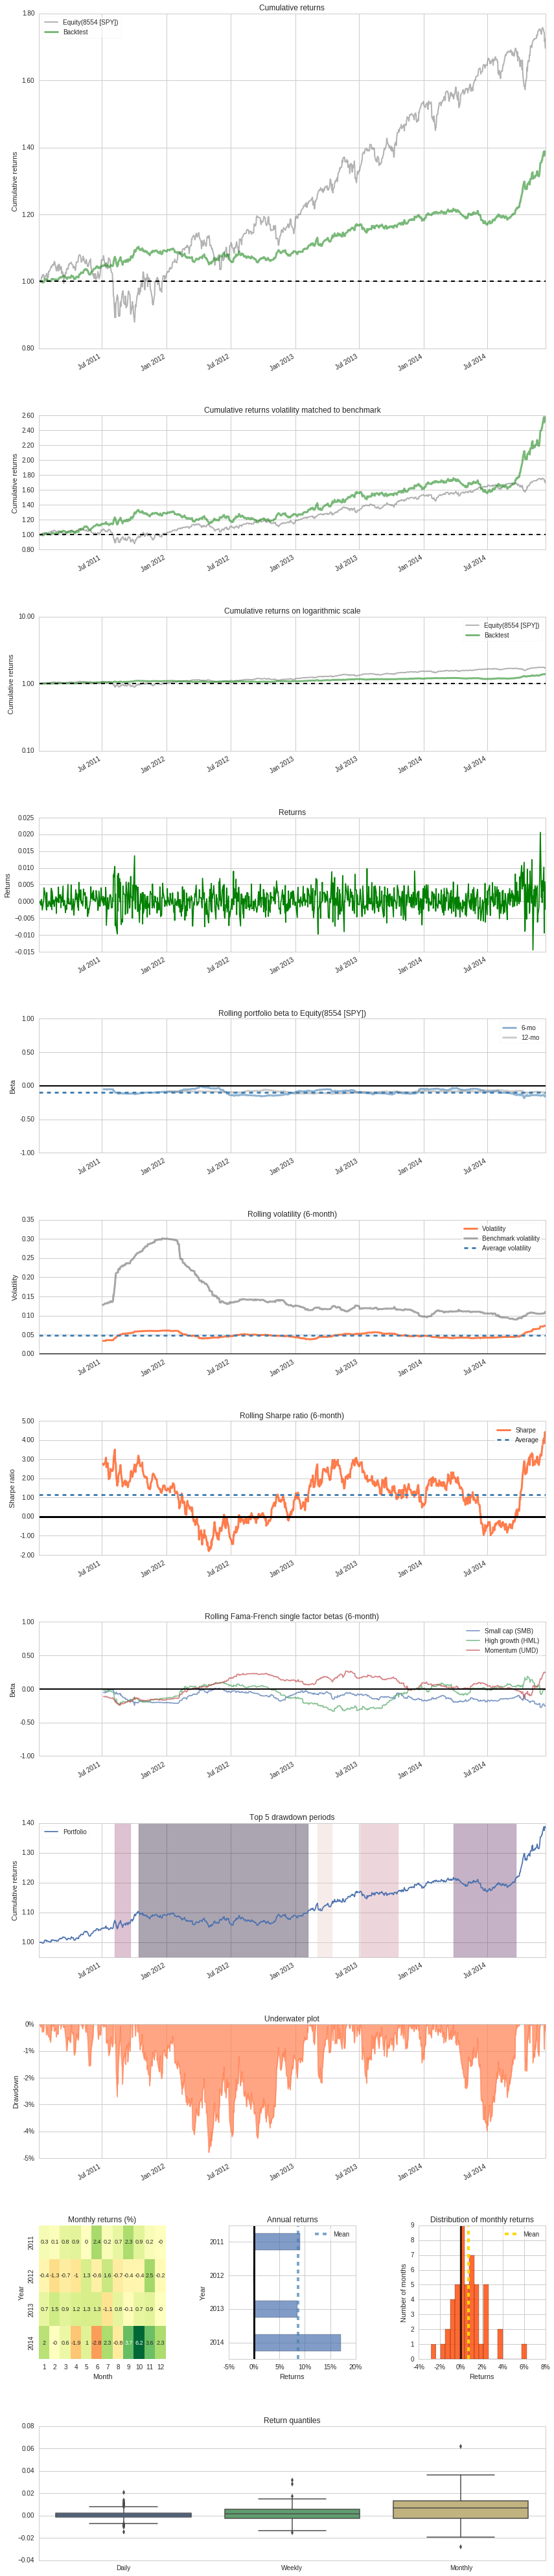

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.02%,-0.97%,1.05%
Fukushima,-0.04%,-0.41%,0.51%
EZB IR Event,-0.00%,-0.46%,0.51%
Apr14,-0.08%,-0.47%,0.49%
Oct14,0.26%,-0.89%,1.17%
Recovery,0.02%,-0.97%,1.36%
New Normal,0.05%,-1.45%,2.06%


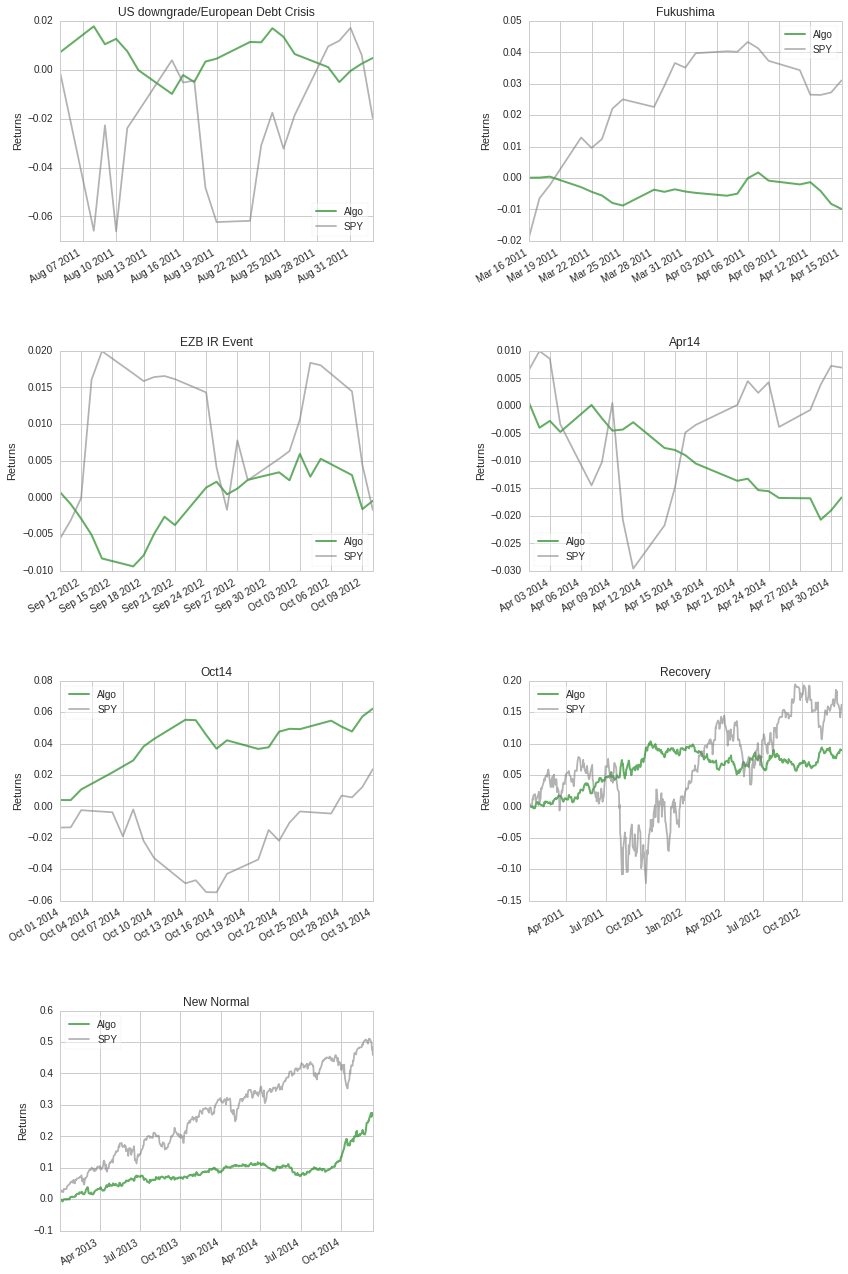

Top 10 long positions of all time,max
FSLR-32902,1.45%
STX-24518,1.33%
RBN-6529,1.29%
GTAT-36628,1.27%
WDC-8132,1.26%
AMD-351,1.24%
AOL-38989,1.24%
BIG-22657,1.23%
CRUS-1882,1.22%
CAB-26412,1.22%


Top 10 short positions of all time,max
HGSI-10409,-1.98%
LNG-22096,-1.95%
AMLN-374,-1.60%
NAV-5199,-1.51%
OPEN-38418,-1.50%
DF-24814,-1.44%
SHLD-26169,-1.43%
MCP-39960,-1.39%
AMD-351,-1.34%
REGN-6413,-1.34%


Top 10 positions of all time,max
HGSI-10409,1.98%
LNG-22096,1.95%
AMLN-374,1.60%
NAV-5199,1.51%
OPEN-38418,1.50%
FSLR-32902,1.45%
DF-24814,1.44%
SHLD-26169,1.43%
MCP-39960,1.39%
AMD-351,1.34%


All positions ever held,max
HGSI-10409,1.98%
LNG-22096,1.95%
AMLN-374,1.60%
NAV-5199,1.51%
OPEN-38418,1.50%
FSLR-32902,1.45%
DF-24814,1.44%
SHLD-26169,1.43%
MCP-39960,1.39%
AMD-351,1.34%


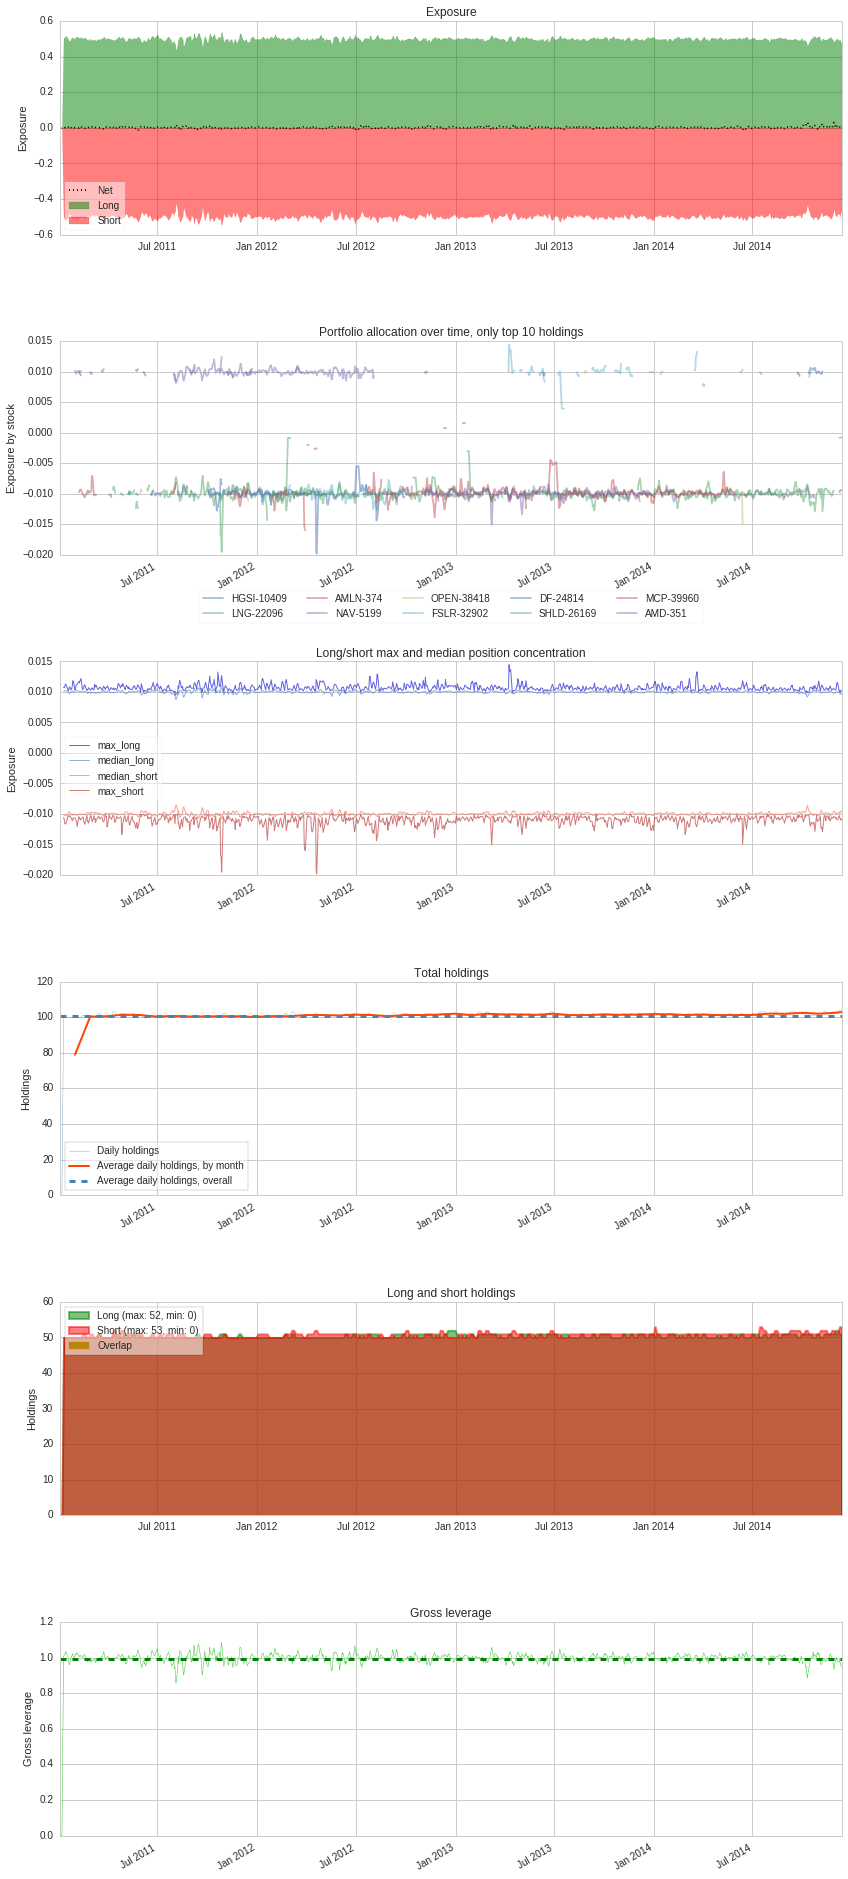

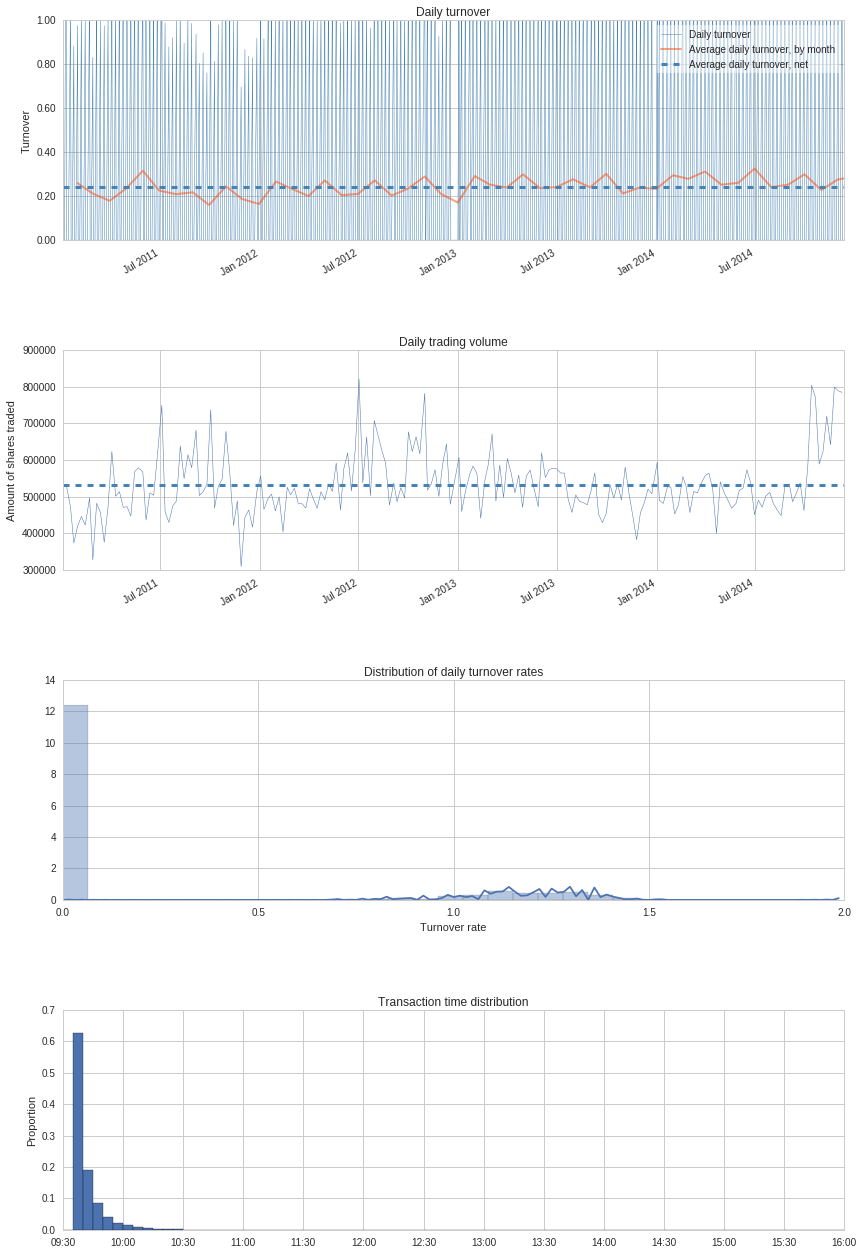

## Performance Relative to Common Risk Factors

Summary Statistics,
Annualized Specific Return,7.40%
Annualized Common Return,1.15%
Annualized Total Return,8.62%
Specific Sharpe Ratio,1.83


Exposures Summary,Average Risk Factor Exposure,Annualized Return,Cumulative Return
basic_materials,-0.03,-0.56%,-2.20%
consumer_cyclical,0.04,0.75%,3.00%
financial_services,0.02,0.48%,1.90%
real_estate,-0.04,-0.73%,-2.83%
consumer_defensive,0.02,0.35%,1.39%
health_care,0.01,0.01%,0.02%
utilities,-0.00,-0.13%,-0.52%
communication_services,-0.00,-0.00%,-0.01%
energy,-0.11,-1.09%,-4.21%
industrials,0.02,0.75%,3.00%


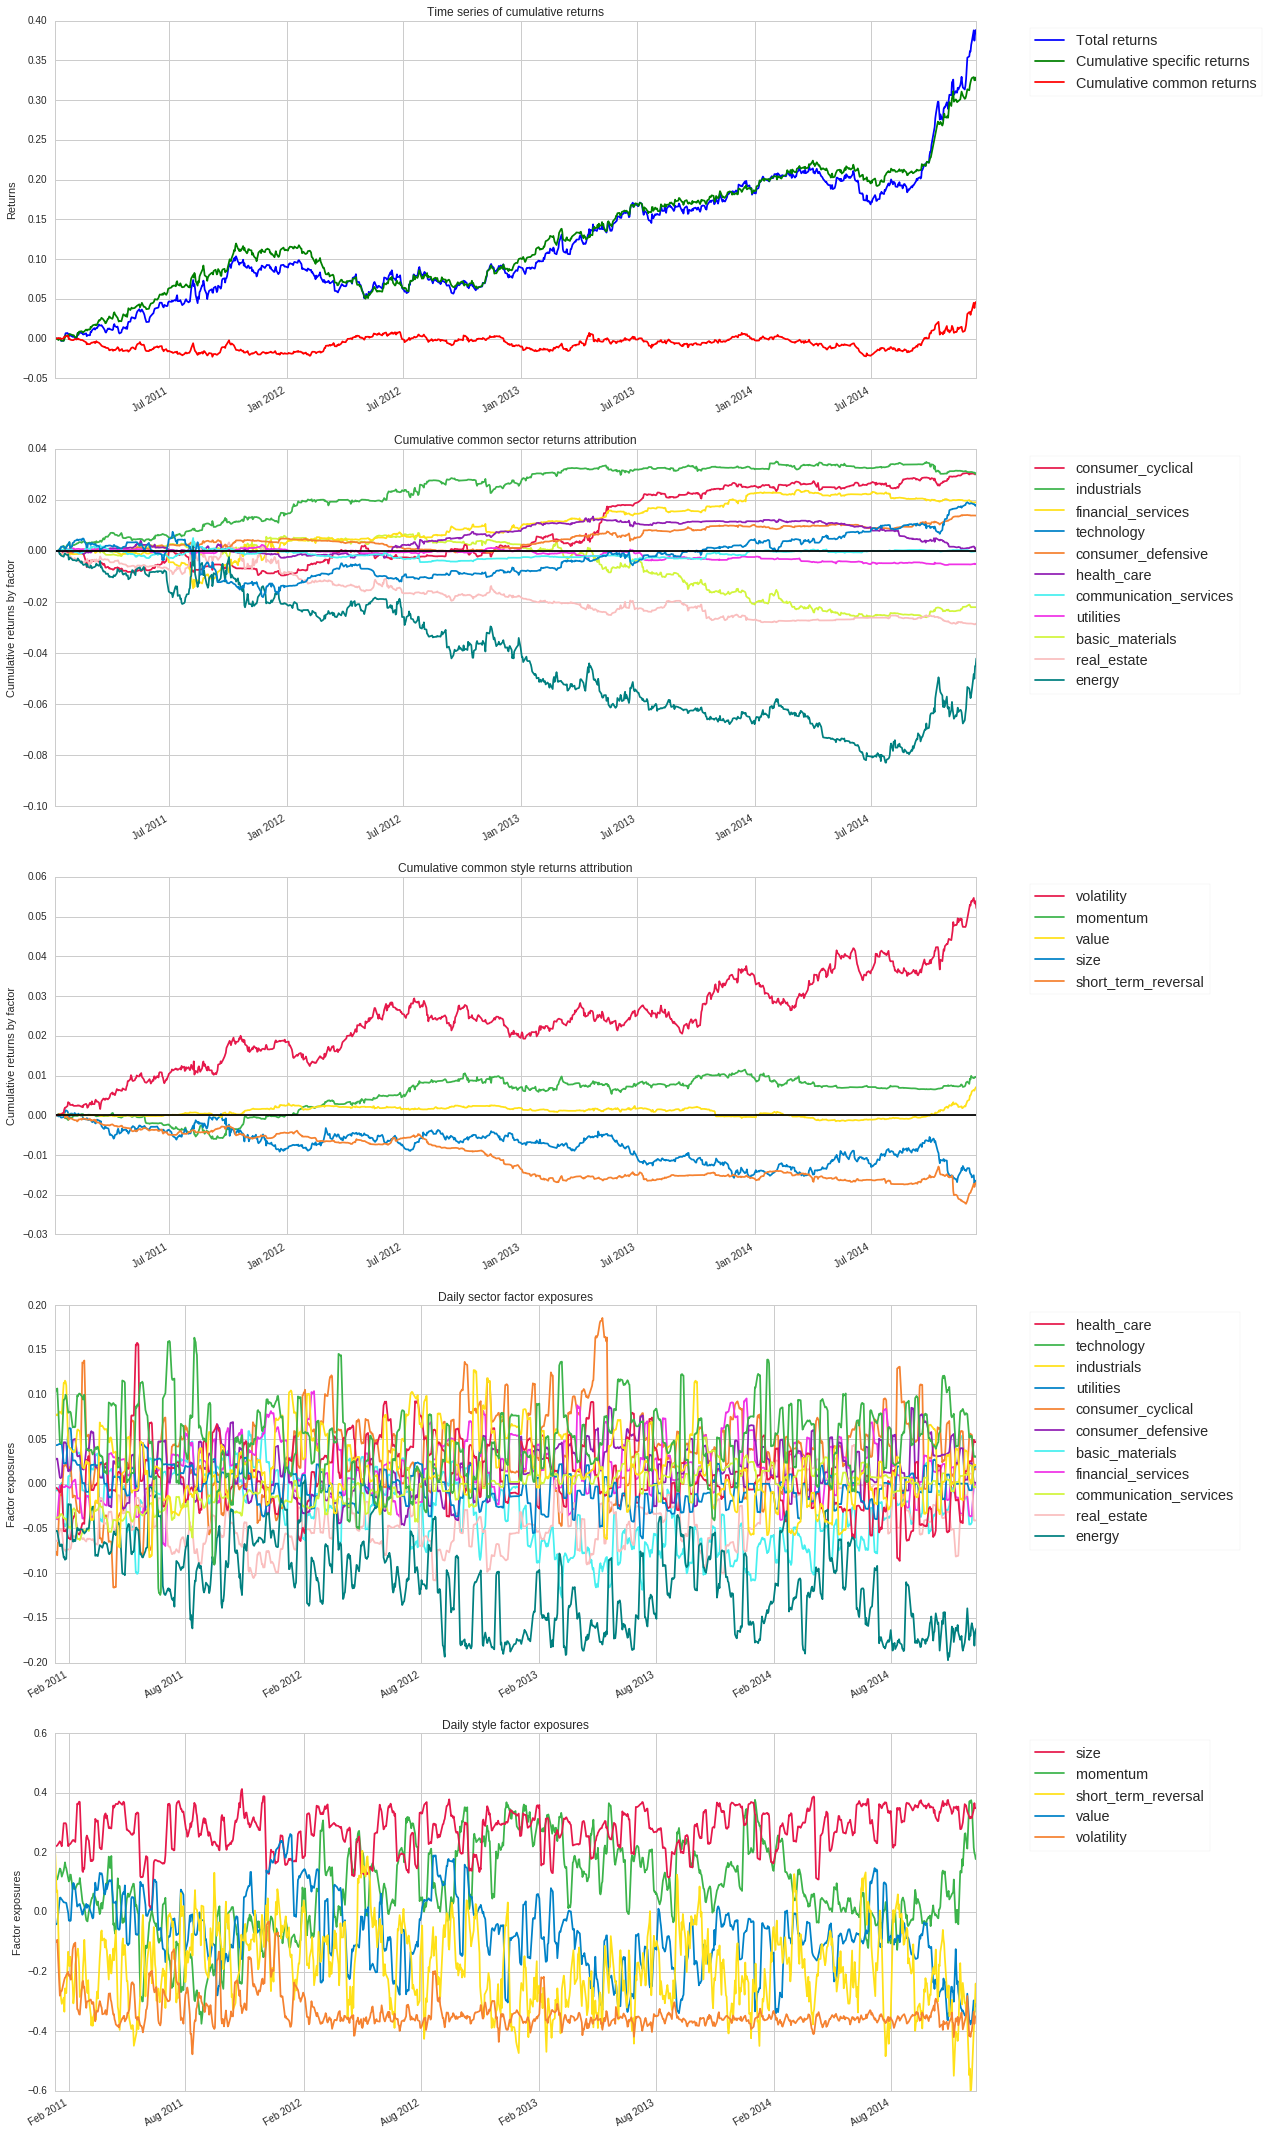

In [11]:
bt.create_full_tear_sheet()